# Week 11: Hierarchical clustering

## Goals 
- Examples of hierarchical clustering
- Perform hierarchical clustering
- Compare to $k$-means

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering

## Wine

Let's take a look at SLINK and CLINK using a wine data set.

Data set was obtained from [kaggle.com](https://www.kaggle.com/datasets/harrywang/wine-dataset-for-clustering/). The original [data set](https://archive.ics.uci.edu/dataset/109/wine) is publicly available with the [CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/legalcode) license. 

In [2]:
df = pd.read_csv("data/wine-clustering.csv")
df.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


We have 13 columns, so our data points live in $\mathbb{R}^{13}$.

Let's quickly run a PCA and project the data onto the first two principal components. 

Here is code to scale the data, but we could probably avoid it. We definitely need to translate the data, so that the mean is at the origin.

In [3]:
def mat_to_rescaled_mat(Z):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(Z)
    return scaler.transform(Z)

We'll work with two data sets: `X` and `Z`.

- `X` : raw data 
- `Z` : scaled data (via StandardScaler in `sklearn`)

From `scikit-learn`'s [website](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html):

> Standardization of a dataset is a common requirement for many 
> machine learning estimators: they might behave badly if the 
> individual features do not more or less look like standard 
> normally distributed data (e.g. Gaussian with 0 mean and 
> unit variance).

In [4]:
X = df.to_numpy()
Z = mat_to_rescaled_mat(X)
print("First 3 rows of X:")
print(X[:3,:])
print("\nFirst 3 rows of Z:")
print(Z[:3,:])

First 3 rows of X:
[[1.423e+01 1.710e+00 2.430e+00 1.560e+01 1.270e+02 2.800e+00 3.060e+00
  2.800e-01 2.290e+00 5.640e+00 1.040e+00 3.920e+00 1.065e+03]
 [1.320e+01 1.780e+00 2.140e+00 1.120e+01 1.000e+02 2.650e+00 2.760e+00
  2.600e-01 1.280e+00 4.380e+00 1.050e+00 3.400e+00 1.050e+03]
 [1.316e+01 2.360e+00 2.670e+00 1.860e+01 1.010e+02 2.800e+00 3.240e+00
  3.000e-01 2.810e+00 5.680e+00 1.030e+00 3.170e+00 1.185e+03]]

First 3 rows of Z:
[[ 1.51861254 -0.5622498   0.23205254 -1.16959318  1.91390522  0.80899739
   1.03481896 -0.65956311  1.22488398  0.25171685  0.36217728  1.84791957
   1.01300893]
 [ 0.24628963 -0.49941338 -0.82799632 -2.49084714  0.01814502  0.56864766
   0.73362894 -0.82071924 -0.54472099 -0.29332133  0.40605066  1.1134493
   0.96524152]
 [ 0.19687903  0.02123125  1.10933436 -0.2687382   0.08835836  0.80899739
   1.21553297 -0.49840699  2.13596773  0.26901965  0.31830389  0.78858745
   1.39514818]]


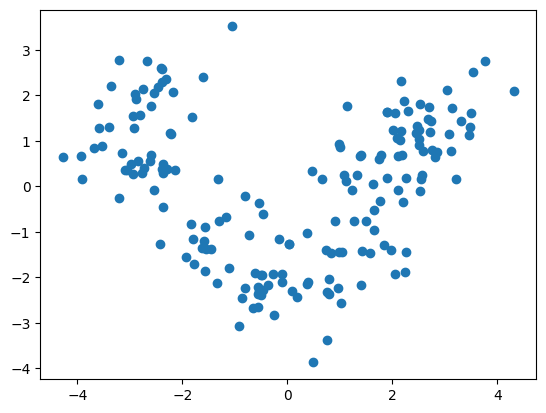

In [8]:
pca = PCA(n_components=2)
pca.fit(Z)
Y = pca.transform(Z)
plt.figure(1)
_ = plt.scatter(Y[:,0], Y[:,1])

Let's also briefly look at a $k$-means clustering. 

First let's see if we can get any information from an elbow plot.

In [9]:
def MyKMeans(k, data):
    return KMeans(n_clusters=k, n_init="auto").fit(data)

def ElbowMethodPlot(data, N):
    import matplotlib.pyplot as plt

    def WCSS(data, kmeans):
        from functools import reduce
        ord_cents = map(lambda i: kmeans.cluster_centers_[i], kmeans.labels_)
        tups = zip(data, ord_cents)
        dist2 = lambda t: np.linalg.norm(t[0] - t[1])**2
        return reduce(lambda x, y: x + dist2(y), tups, 0)

    KMEANS = [MyKMeans(k, data) for k in range(1, N + 1)]
    WCSS_vals = [WCSS(data, kmeans) for kmeans in KMEANS]

    plt.figure(1)
    plt.grid()
    plt.plot(WCSS_vals)
    plt.xticks(ticks=range(N), labels=range(1, N+1))
    return plt

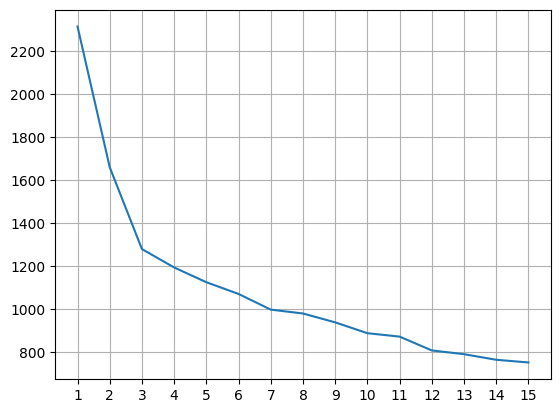

In [10]:
plot = ElbowMethodPlot(Z, 15)

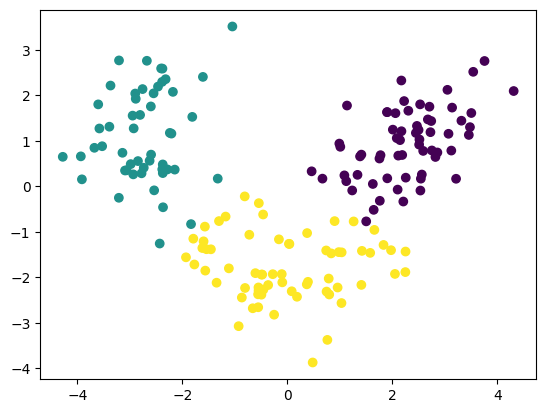

In [11]:
kmeans_data = MyKMeans(3, Z)
plt.clf()
_ = plt.scatter(Y[:,0], Y[:,1], c=kmeans_data.labels_)

Now we will do this with a hierarchical clustering algorithm.

We will use `scikit-learn` to do hierarchical clustering, but `scipy` has a very good function as well. Moreover, `scipy` has a `dendrogram` function, which is built around their own clustering algorithm.

Instead, we will just use the following dendrogram plotting function.

In [12]:
def plot_dendrogram(model, **kwargs):
    import numpy as np
    # from matplotlib import pyplot as plt
    from scipy.cluster.hierarchy import dendrogram
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [13]:
def SLINK(data):
    return AgglomerativeClustering(n_clusters=None, distance_threshold=0, linkage="single").fit(data)

def CLINK(data):
    return AgglomerativeClustering(n_clusters=None, distance_threshold=0, linkage="complete").fit(data)

def ALINK(data):
    return AgglomerativeClustering(n_clusters=None, distance_threshold=0, linkage="average").fit(data)

def WLINK(data):
    return AgglomerativeClustering(n_clusters=None, distance_threshold=0, linkage="ward").fit(data)

def HCluster(k, data, link="ward"):
    return AgglomerativeClustering(n_clusters=k, linkage=link).fit(data)

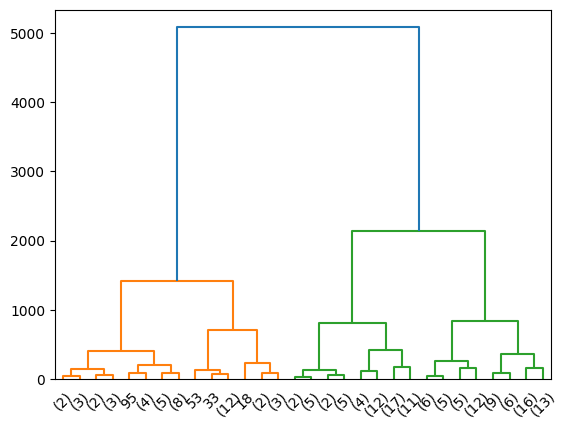

In [14]:
plot_dendrogram(WLINK(X), truncate_mode="level", p=4)

Let's see how hierarchical clustering compares with out $k$-means clusters.

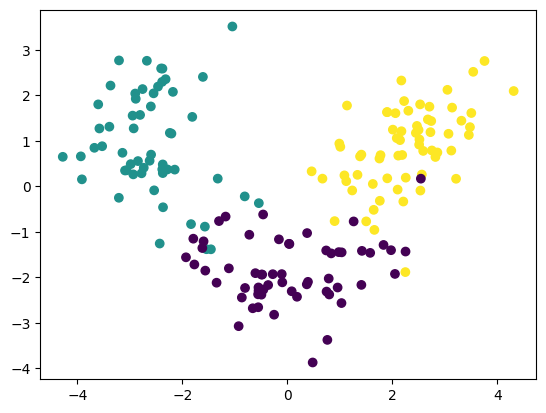

In [15]:
hclus_data = HCluster(3, Z, link="ward")
plt.clf()
_ = plt.scatter(Y[:,0], Y[:,1], c=hclus_data.labels_)

It was at this stage that I dug through the original data for more information about the wine.

I found the following quote:

> These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars.
> 
> The analysis determined the quantities of 13 constituents found in each of the three types of wines. 

🤯🤯🤯

## Ward-linkage

Recall we have given formulae for the "single", "complete" and "average" linkages.

If $C_1$ and $C_2$ are finite (disjoint) subsets of $\mathbb{R}^m$, then 
1. `SINGLE` is given as
$$
    d(C_1, C_2) = \min\left\{ \| x - y\| : x\in C_1, y\in C_2 \right\},
$$
2. `COMPLETE` is given as 
$$
    d(C_1, C_2) = \max\left\{ \| x - y\| : x\in C_1, y\in C_2 \right\},
$$
3. `AVERAGE` is given as 
$$
    d(C_1, C_2) = \sum_{x \in C_1} \sum_{y\in C_2} \dfrac{\|x - y\|}{\# C_1 \cdot \# C_2},
$$
4. `WARD` is given as 
$$
    d(C_1, C_2) = \sum_{x\in C_1}\sum_{y\in C_2} \dfrac{\|x - y\|^2}{\# C_1 + \# C_2} - \sum_{x\in C_1}\sum_{y\in C_1} \dfrac{\|x - y\|^2}{\# C_1} - \sum_{x\in C_2}\sum_{y\in C_2} \dfrac{\|x - y\|^2}{\# C_2}.
$$

The idea behind the `WARD` linkage is to join clusters $C_1$ and $C_2$ only if they are the pair that minimizes the WCSS (Within-Cluster Sum of Squares).

We will use `WARD` here in this notebook, but you do not need to commit it to memory. 

## Examples with hierarchical clustering

Let's go through the same data sets we went through with $k$-means and see how hierarchical compares.

We will use `HCluster` defined above, and for plotting let's use the following code. Similar format as `Voronoi` from Week10.

In [16]:
def plot_hcluster(data, hcluster=None):
    import matplotlib.cm as cm
    import matplotlib.pyplot as plt 
    plt.figure(1)
    plt.clf()
    if hcluster:
        plt.scatter(data[:,0], data[:,1], c=hcluster.labels_)
    else:
        plt.scatter(data[:,0], data[:,1], c="black")
    return plt 

### Three clear clusters

First up is `data/three_clusters_clear.csv`. Just to remind us what it looks like.

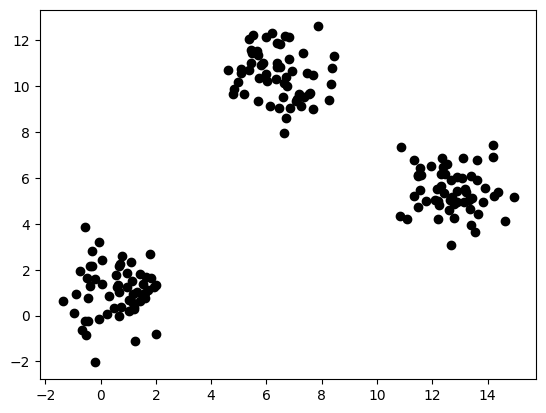

In [17]:
data_3c = pd.read_csv("data/three_clusters_clear.csv").to_numpy()
plot = plot_hcluster(data_3c)

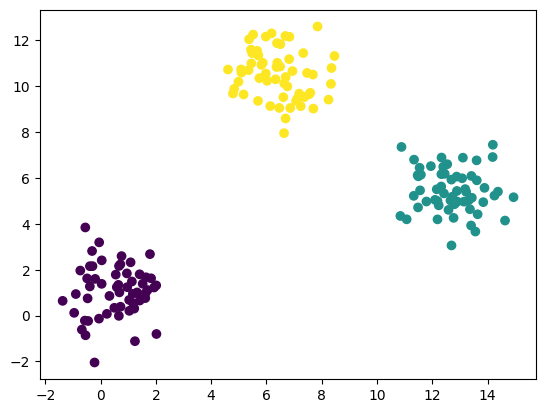

In [18]:
hcluster_3c = HCluster(3, data_3c, link="single")
plot = plot_hcluster(data_3c, hcluster=hcluster_3c)

What does the corresponding dendrogram look like?

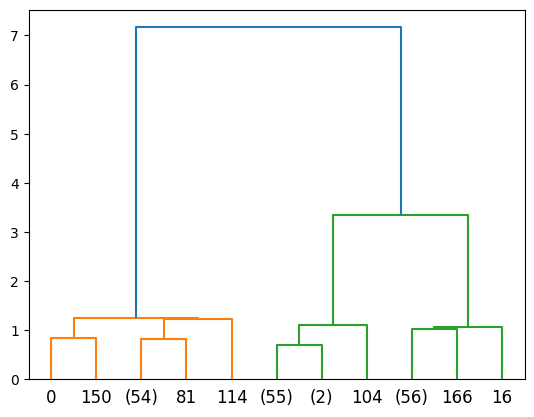

In [19]:
plot = plot_dendrogram(SLINK(data_3c), truncate_mode="level", p=3)

We can see the three clusters:
- there are 58 points in orange: 54 points plus points labeled 0, 150, 81, and 114.
- there are two sets of 58 points in green.
  - left: 55 points plus 2 points plus a point labeled 104.
  - right: 56 points plus points labeled 166 and 16.

### Three vague clusters

In [ ]:
data_3v = pd.read_csv("data/three_clusters_vague.csv").to_numpy()
plot = plot_hcluster(data_3v)

In [ ]:
hcluster_3v = HCluster(3, data_3v, link="single")
plot = plot_hcluster(data_3v, hcluster=hcluster_3v)

### Two unbalanced clusters

It was only now that I realised I had a typo in my `csv` file...

In [ ]:
data_2u = pd.read_csv("data/two_clusters_unbalanced.csv").to_numpy()
plot = plot_hcluster(data_2u)

In [ ]:
hcluster_2u = HCluster(2, data_2u, link="single")
plot = plot_hcluster(data_2u, hcluster=hcluster_2u)

### The 'impossible' data set

We can see hierarchical clustering shine compared to $k$-means with this 'impossible' data set.

In [ ]:
data_i = pd.read_csv("data/impossible.csv").to_numpy()
plot = plot_hcluster(data_i)

The number of clusters is not so clear-cut as the previous examples. Let's try a few.

In [ ]:
hcluster_i = HCluster(2, data_i, link="single")
plot = plot_hcluster(data_i, hcluster=hcluster_i)

## Try it yourself!

There are five data sets to play around with. Feel free to use the functions here: 
- `plot_dendrogram` with:
  - `SLICK`, `CLINK`, `ALINK`, `WLINK`,
- `HCluster`, 
- `plot_hcluster`.

Here are some question to consider.
1. How many clusters are there in the data? 
2. Do the clusters seem to be unambiguous? 
3. What other intrepretations are there?
4. Does the hierarchical clustering do what you expect? Why? 
5. Does one linkage perform far better (or far worse) than the others? Why do you think?

Discuss this with a neighbour.

Data sets:
- `extra_1.csv`
- `extra_2.csv`
- `extra_3.csv`
- `extra_4.csv`
- `extra_5.csv`